69000
69000

=== Fold 1 시작 ===


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fold [1], Epoch [1/30], Train Acc: 42.82%, Val Acc: 59.53%
Fold [1], Epoch [2/30], Train Acc: 63.39%, Val Acc: 70.23%
Fold [1], Epoch [3/30], Train Acc: 72.92%, Val Acc: 76.70%
Fold [1], Epoch [4/30], Train Acc: 77.22%, Val Acc: 80.08%
Fold [1], Epoch [5/30], Train Acc: 80.68%, Val Acc: 82.78%
Fold [1], Epoch [6/30], Train Acc: 82.89%, Val Acc: 84.36%
Fold [1], Epoch [7/30], Train Acc: 84.70%, Val Acc: 84.98%
Fold [1], Epoch [8/30], Train Acc: 86.39%, Val Acc: 85.76%
Fold [1], Epoch [9/30], Train Acc: 87.64%, Val Acc: 86.26%
Fold [1], Epoch [10/30], Train Acc: 88.92%, Val Acc: 86.63%
Fold [1], Epoch [11/30], Train Acc: 89.72%, Val Acc: 87.30%
Fold [1], Epoch [12/30], Train Acc: 90.57%, Val Acc: 88.24%
Fold [1], Epoch [13/30], Train Acc: 91.40%, Val Acc: 87.95%
Fold [1], Epoch [14/30], Train Acc: 91.93%, Val Acc: 88.36%
Fold [1], Epoch [15/30], Train Acc: 92.55%, Val Acc: 88.12%
Fold [1], Epoch [16/30], Train Acc: 93.06%, Val Acc: 88.63%
Fold [1], Epoch [17/30], Train Acc: 93.39%, Val A

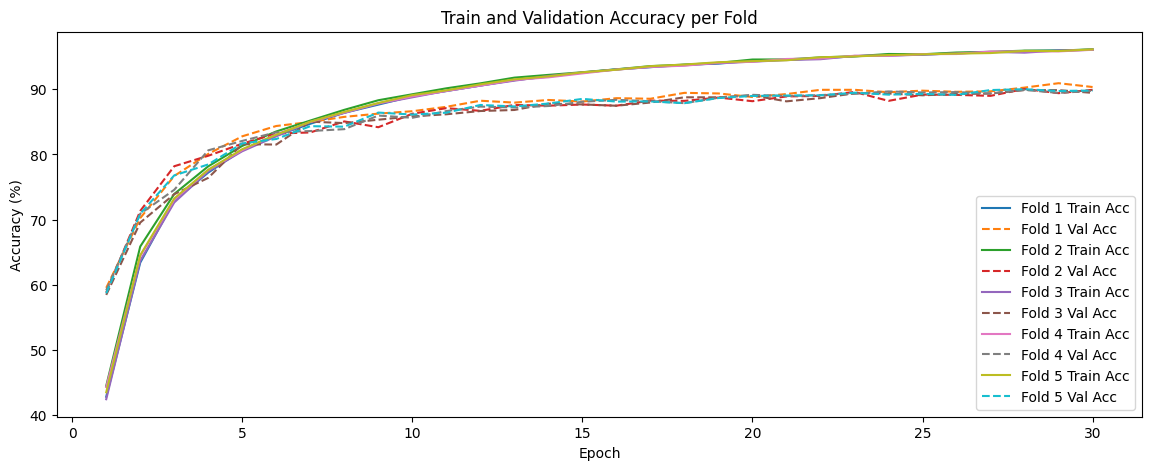

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, Subset, SubsetRandomSampler
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import random

# 1. 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 데이터 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B0는 224x224 입력 크기 사용
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))  # CIFAR-10의 정규화 값 사용
])

# 3. 사용자 데이터셋 불러오기
trainset_path = 'C:/Users/USER/Desktop/Semester2/train_data'
user_dataset = datasets.ImageFolder(root=trainset_path, transform=transform)

# 4. CIFAR-10 데이터셋 불러오기 (훈련 데이터만 사용)
cifar10_dataset = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=transform)

# 5. 사용자 데이터셋과 CIFAR-10 데이터셋 통합
combined_dataset = ConcatDataset([user_dataset, cifar10_dataset])
combined_labels = np.concatenate((np.array([label for _, label in user_dataset.samples]),
                                  np.array(cifar10_dataset.targets)))

# 6. Augmentation 추가
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

augmented_user_dataset = datasets.ImageFolder(root=trainset_path, transform=augmentation_transform)
augmented_cifar10_dataset = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=augmentation_transform)
augmented_combined_dataset = ConcatDataset([augmented_user_dataset, augmented_cifar10_dataset])

# Augmented dataset에서 15,000개 샘플 무작위 추출
augmented_indices = random.sample(range(len(augmented_combined_dataset)), 15000)
augmented_subset = Subset(augmented_combined_dataset, augmented_indices)

# 원본 combined_dataset과 augmented_subset 합치기
final_combined_dataset = ConcatDataset([combined_dataset, augmented_subset])

# final_combined_dataset의 레이블 배열 생성
augmented_labels = np.array([augmented_combined_dataset[i][1] for i in augmented_indices])
final_combined_labels = np.concatenate((combined_labels, augmented_labels))

print(len(final_combined_dataset))
print(len(final_combined_labels))

# 7. K-Fold Cross Validation 설정
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_accuracies = []  # 각 폴드의 검증 정확도 저장
train_accuracies, val_accuracies = [], []  # 전체 에포크의 정확도 저장

# 8. Cross Validation 학습 및 평가
num_epochs = 30
for fold, (train_idx, val_idx) in enumerate(kf.split(np.zeros(len(final_combined_labels)), final_combined_labels)):
    print(f"\n=== Fold {fold + 1} 시작 ===")

    # Fold별 데이터셋 분리
    train_subset = Subset(final_combined_dataset, train_idx)
    val_subset = Subset(final_combined_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=1)

    # EfficientNet-B0 모델 설정 (사전 학습 없음)
    model = models.efficientnet_b0(pretrained=False)
    num_classes = 10  # CIFAR-10의 클래스 수 (사용자 데이터셋도 동일한 클래스 수로 가정)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model = model.to(device)

    # 손실 함수 및 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Fold 학습 및 검증
    fold_train_acc, fold_val_acc = [], []
    for epoch in range(num_epochs):
        # === 학습 ===
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        # 학습 정확도 기록
        train_acc = 100. * correct_train / total_train
        fold_train_acc.append(train_acc)

        # === 검증 ===
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        # 검증 정확도 기록
        val_acc = 100. * correct_val / total_val
        fold_val_acc.append(val_acc)

        print(f"Fold [{fold + 1}], Epoch [{epoch+1}/{num_epochs}], "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # 각 폴드별 학습 및 검증 정확도 기록
    train_accuracies.append(fold_train_acc)
    val_accuracies.append(fold_val_acc)
    fold_accuracies.append(val_acc)  # 마지막 에포크의 검증 정확도 저장

# 9. 최종 K-Fold 평균 정확도 출력
print("\n=== 최종 K-Fold 평균 정확도 ===")
print(f"Average {k}-Fold Accuracy: {np.mean(fold_accuracies):.2f}%")

# 10. 정확도 시각화
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

# 폴드별 학습 및 검증 정확도 변화 시각화
for i in range(k):
    plt.plot(epochs_range, train_accuracies[i], label=f'Fold {i+1} Train Acc')
    plt.plot(epochs_range, val_accuracies[i], label=f'Fold {i+1} Val Acc', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy per Fold')
plt.legend(loc='best')
plt.show()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms, datasets, models
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random

# 총 데이터셋 결합 (기존 사용자 데이터셋 + CIFAR-10 데이터셋 + Augmentation 적용된 데이터셋)
combined_dataset2 = final_combined_dataset
combined_labels2 = final_combined_labels

# 4. CutMix를 적용하는 함수
def cutmix_data(input, target, beta=1.0):
    lam = np.random.beta(beta, beta)
    rand_index = torch.randperm(input.size()[0]).to(device)
    target_a = target
    target_b = target[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
    input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size(-1) * input.size(-2)))
    return input, target_a, target_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

# 5. K-Fold Cross Validation 설정
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
num_epochs = 30
batch_size = 32
cutmix_prob = 0.2
train_accuracies2, val_accuracies2 = [], []

# 6. 모델 학습 및 검증 루프 (model2 사용)
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(combined_labels2)), combined_labels2)):
    print(f"\n=== Fold {fold + 1}/{k} ===")
    train_subset = Subset(combined_dataset2, train_idx)
    val_subset = Subset(combined_dataset2, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model2 = models.efficientnet_b0(pretrained=False)
    model2.classifier[1] = nn.Linear(model2.classifier[1].in_features, 10)
    model2 = model2.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model2.parameters(), lr=0.001)  # 학습률 고정

    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        model2.train()
        correct_train, total_train = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # CutMix 적용 여부 결정
            r = np.random.rand(1)
            if r < cutmix_prob:
                inputs, target_a, target_b, lam = cutmix_data(inputs, targets)
                outputs = model2(inputs)
                loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
            else:
                outputs = model2(inputs)
                loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = outputs.max(1)
            correct_train += preds.eq(targets).sum().item()
            total_train += targets.size(0)

        train_acc = 100 * correct_train / total_train
        train_acc_history.append(train_acc)

        # 검증
        model2.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model2(inputs)
                _, preds = outputs.max(1)
                correct_val += preds.eq(targets).sum().item()
                total_val += targets.size(0)

        val_acc = 100 * correct_val / total_val
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    train_accuracies2.append(train_acc_history)
    val_accuracies2.append(val_acc_history)

# 7. 학습 및 검증 정확도 시각화
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))
for i in range(k):
    plt.plot(epochs_range, train_accuracies2[i], label=f'Fold {i+1} Train Acc')
    plt.plot(epochs_range, val_accuracies2[i], label=f'Fold {i+1} Val Acc', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy per Fold (CutMix 적용)')
plt.legend()
plt.show()



=== Fold 1/5 ===


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30], Train Acc: 39.35%, Val Acc: 58.54%
Epoch [2/30], Train Acc: 58.90%, Val Acc: 72.53%
Epoch [3/30], Train Acc: 66.76%, Val Acc: 76.08%
Epoch [4/30], Train Acc: 71.78%, Val Acc: 78.97%
Epoch [5/30], Train Acc: 74.44%, Val Acc: 81.30%
Epoch [6/30], Train Acc: 76.39%, Val Acc: 82.70%
Epoch [7/30], Train Acc: 78.29%, Val Acc: 85.10%
Epoch [8/30], Train Acc: 79.81%, Val Acc: 84.99%
Epoch [9/30], Train Acc: 80.57%, Val Acc: 86.15%
Epoch [10/30], Train Acc: 81.89%, Val Acc: 86.28%
Epoch [11/30], Train Acc: 82.80%, Val Acc: 87.75%
Epoch [12/30], Train Acc: 83.19%, Val Acc: 87.00%
Epoch [13/30], Train Acc: 85.26%, Val Acc: 87.81%
Epoch [14/30], Train Acc: 84.80%, Val Acc: 88.13%
Epoch [15/30], Train Acc: 85.69%, Val Acc: 86.30%
Epoch [16/30], Train Acc: 85.56%, Val Acc: 88.63%
Epoch [17/30], Train Acc: 86.76%, Val Acc: 88.40%
Epoch [18/30], Train Acc: 86.42%, Val Acc: 88.33%
Epoch [19/30], Train Acc: 86.57%, Val Acc: 88.96%
Epoch [20/30], Train Acc: 87.76%, Val Acc: 89.43%
Epoch [21

KeyboardInterrupt: 